# Laboratorium 2


### Konfiguracja

In [65]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as mcoll
import matplotlib.colors as mcolors
from matplotlib.widgets import Button
import json as js
import random
import functools

class _Button_callback(object):
    def __init__(self, scenes):
        self.i = 0
        self.scenes = scenes

    def set_axis(self, ax):
        self.ax = ax
        
    def next(self, event):
        self.i = (self.i + 1) % len(scenes)
        self.draw()

    def prev(self, event):
        self.i = (self.i - 1) % len(scenes)
        self.draw()
        
    def draw(self):
        self.ax.clear()
        for collection in scenes[self.i].points:
            if len(collection.points) > 0:
                self.ax.scatter(*zip(*(np.array(collection.points))), c=collection.color, marker=collection.marker)
        for collection in scenes[self.i].lines:
            self.ax.add_collection(collection.get_collection())
        self.ax.autoscale()
        plt.draw()

### Interfejsy

[Dostępne kolory](https://matplotlib.org/3.1.1/gallery/color/named_colors.html)

[Dostępne znaczniki punktów](https://matplotlib.org/3.1.1/api/markers_api.html#module-matplotlib.markers)

In [2]:
class Scene:
    def __init__(self, points=[], lines=[]):
        self.points=points
        self.lines=lines

class PointsCollection:
    def __init__(self, points = [], color = None, marker = None):
        self.points = np.array(points)
        self.color = color
        self.marker = marker

class LinesCollection:
    def __init__(self, lines = [], color = None):
        self.color = color
        self.lines = lines
        
    def add(self, line):
        self.lines.append(line)
        
    def get_collection(self):
        if self.color:
            return mcoll.LineCollection(self.lines, colors=mcolors.to_rgba(self.color))
        else:
            return mcoll.LineCollection(self.lines)
            


class Plot:
    def __init__(self, scenes = [], json = None):
        if json is None:
            self.scenes = scenes
        else:
            self.scenes = [Scene([PointsCollection(pointsCol) for pointsCol in scene["points"]], 
                                 [LinesCollection(linesCol) for linesCol in scene["lines"]]) 
                           for scene in js.loads(json)]
        
    def __configure_buttons(self, callback):
        plt.subplots_adjust(bottom=0.2)
        axprev = plt.axes([0.6, 0.05, 0.15, 0.075])
        axnext = plt.axes([0.76, 0.05, 0.15, 0.075])
        bnext = Button(axnext, 'Następny')
        bnext.on_clicked(callback.next)
        bprev = Button(axprev, 'Poprzedni')
        bprev.on_clicked(callback.prev)
        return [bprev, bnext]

    def draw(self):
        plt.close()
        callback = _Button_callback(self.scenes)
        self.widgets = self.__configure_buttons(callback)
        callback.set_axis(plt.axes())
        plt.show()
        callback.draw()
        
    def toJSON(self):
        return js.dumps([{"points": [pointCol.points.tolist() for pointCol in scene.points], 
                          "lines":[linesCol.lines for linesCol in scene.lines]} 
                         for scene in self.scenes])
    

### Przykład użycia

<IPython.core.display.Javascript object>


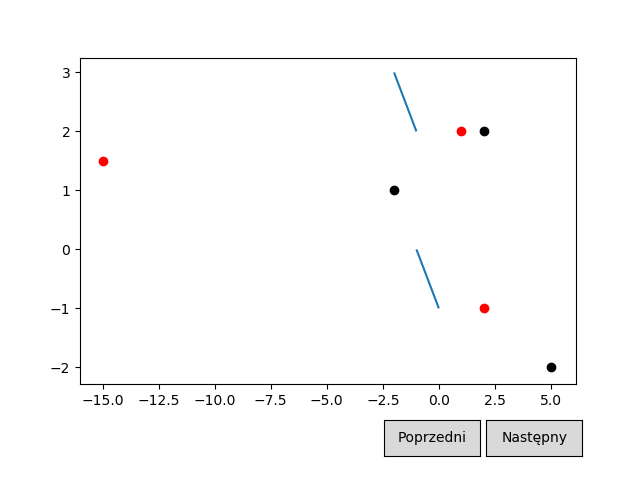

In [3]:
%matplotlib notebook

scenes=[Scene([PointsCollection([(1, 2), (3, 1.5), (2, -1)]), 
               PointsCollection([(5, -2), (2, 2), (-2, -1)], 'green', marker = "^")], 
              [LinesCollection([[(1,2),(2,3)], [(0,1),(1,0)]], 'orange')]), 
        Scene([PointsCollection([(1, 2), (-15, 1.5), (2, -1)], 'red'), 
               PointsCollection([(5, -2), (2, 2), (-2, 1)], 'black')], 
              [LinesCollection([[(-1,2),(-2,3)], [(0,-1),(-1,0)]])])]

plot = Plot(scenes)
plot.draw() 


### Rozwiązanie

#### Zbiory punktów i funkcje pomocnicze

In [4]:
def random_points(n = 100, a = -100, b = 100):
    return [(random.uniform(a, b), random.uniform(a, b)) for i in range(n)]

In [51]:
def random_points_on_circle(n = 100, s = (0,0), r = 10):
    rand = 4*np.random.random(n)
    return [(r*np.cos((np.pi/2)*i)+s[0], r*np.sin((np.pi/2)*i)+s[1]) for i in rand]

In [29]:
def points_to_vector(a, b):
    return np.array([b[0]-a[0], b[1]-a[1]])

In [34]:
def point_on_line(r, p, v):
    return (p[0]+v[0]*r, p[1]+v[1]*r)

In [43]:
def random_points_on_rectangle(n = 100, a = (-10, 10), b = (-10, -10), c = (10, -10), d = (10, 10)):
    rand = np.random.rand(n)
    point_set = []
    ab = points_to_vector(a, b)
    bc = points_to_vector(b, c)
    cd = points_to_vector(c, d)
    da = points_to_vector(d, a)
    
    for i in enumerate(rand):
        if i[0]%4 == 0:
            point_set.append(point_on_line(i[1], a, ab))
        elif i[0]%4 == 1:
            point_set.append(point_on_line(i[1], b, bc))
        elif i[0]%4 == 2:
            point_set.append(point_on_line(i[1], c, cd))
        else:
            point_set.append(point_on_line(i[1], d, da))
            
    return point_set
            
        

In [419]:
def random_points_on_square(n_border = 25, n_diag = 20, a = (0, 0), b = (10, 0), c = (10, 10), d = (0, 10)):
    rand_border_1 = np.random.rand(n_border)
    rand_border_2 = np.random.rand(n_border)
    rand_diag_1 = np.random.rand(n_diag)
    rand_diag_2 = np.random.rand(n_diag)
    point_set = []
    
    ab = points_to_vector(a, b)
    ad = points_to_vector(a, d)
    ac = points_to_vector(a, c)
    bd = points_to_vector(b, d)
    
    for i in range(n_border):
        point_set.append(point_on_line(rand_border_1[i], a, ab))
        point_set.append(point_on_line(rand_border_2[i], a, ad))
        
    for i in range(n_diag):
        point_set.append(point_on_line(rand_diag_1[i], a, ac))
        point_set.append(point_on_line(rand_diag_2[i], b, bd))
        
    random.shuffle(point_set)
    
    return point_set
    

<IPython.core.display.Javascript object>


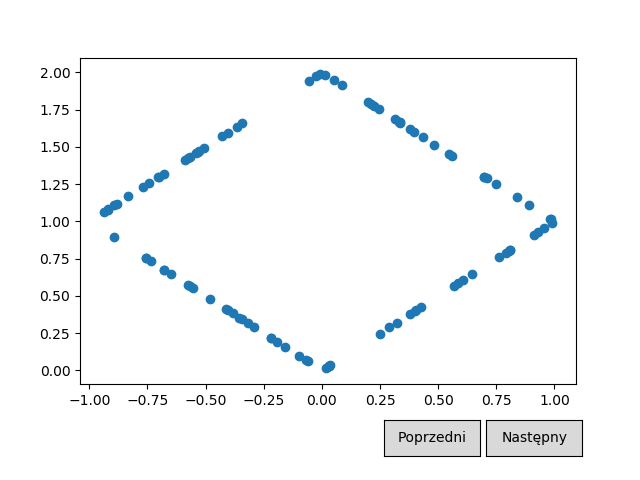

In [219]:
%matplotlib notebook

scenes=[Scene([PointsCollection(random_points()[:10])]), 
        Scene([PointsCollection(random_points_on_circle())]),
       Scene([PointsCollection(random_points_on_rectangle(a=(0,0), b=(1, 1), c=(0, 2), d=(-1, 1)))]),
       Scene([PointsCollection(random_points_on_square())])]

plot = Plot(scenes)
plot.draw()

#### Algorytm Grahama

In [95]:
def det(b, a, c):
    m = np.array([[a[0], a[1], 1], [b[0], b[1], 1], [c[0], c[1], 1]])
    return np.linalg.det(m)

In [92]:
def find_starting_point(points):
    start = points[0]
    
    for point in points:
        if point[1]<start[1]:
            start = point
        elif point[1]==start[1]:
            if point[0]<start[0]:
                start = point
                
    return start

In [99]:
def length(a, b):
    l = np.array([a[0]-b[0], a[1]-b[1]])
    return np.linalg.norm(l)

In [222]:
def eliminate_duplicates(points, p0, eps):
    no_duplicates = []
    curr = points[0]
    for i in range(len(points)):
        ang = det(curr, points[i], p0) 
        if abs(ang) < eps and length(p0, curr)<length(p0, points[i]):
            curr = points[i]
        elif abs(ang)>eps:           
            no_duplicates.append(curr)
            curr = points[i]
        
    no_duplicates.append(curr)
            
    return no_duplicates

In [293]:
def Graham(points, eps = 10**-6):
    p0 = find_starting_point(points)
    
    points = sorted(points, key=functools.cmp_to_key(functools.partial(det, c=p0)))
    points = eliminate_duplicates(points, p0, eps)

    
    stack = []
    stack.append(p0)
    stack.append(points[0])
    stack.append(points[1])
    
    i = 3
    while i< len(points):
        left_side = det(stack[-2], stack[-1], points[i])
        if left_side<-eps:
            stack.append(points[i])
            i+=1
        else:
            stack.pop()
            
    return stack 
    

In [462]:
test_set = random_points_on_rectangle()[:20]
convex_hull_Graham = Graham(test_set)

<IPython.core.display.Javascript object>


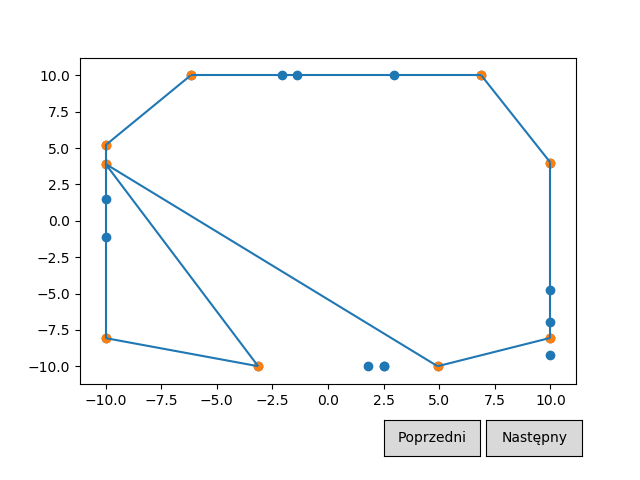

In [463]:
%matplotlib notebook
lines_Graham = [[convex_hull_Graham[i], convex_hull_Graham[(i+1)%len(convex_hull_Graham)]] for i in range(len(convex_hull_Graham))]
scenes=[Scene([PointsCollection(test_set), PointsCollection(convex_hull_Graham)], [LinesCollection(lines_Graham)])]
plot = Plot(scenes)
plot.draw()


#### Algorytm Jarvisa

In [438]:
def find_leftmost(points):
    left = points[0]
    for point in points:
        if point[0]<left[0]:
            left = point
    return point

In [439]:
def find_next(points, p, length):
    next_point = points[0]
    ind = 0
    for i in range(length):
        ang = det(p, next_point, points[i])
        if ang > 0:
            next_point = points[i]
            ind = i
    points[ind] = points[length-1]
    return (next_point, length-1)

In [440]:
def Jarvis(points, eps = 10**-6):
    convex_hull = []
    p0 = find_leftmost(points)
    p_next, length = find_next(points, p0, len(points))
    convex_hull.append(p0)
    
    while not p_next==p0:
        convex_hull.append(p_next)
        p_next, length = find_next(points, p_next, length)
    
    return convex_hull
    

In [441]:
convex_hull_Jarvis = Jarvis(test_set)

<IPython.core.display.Javascript object>


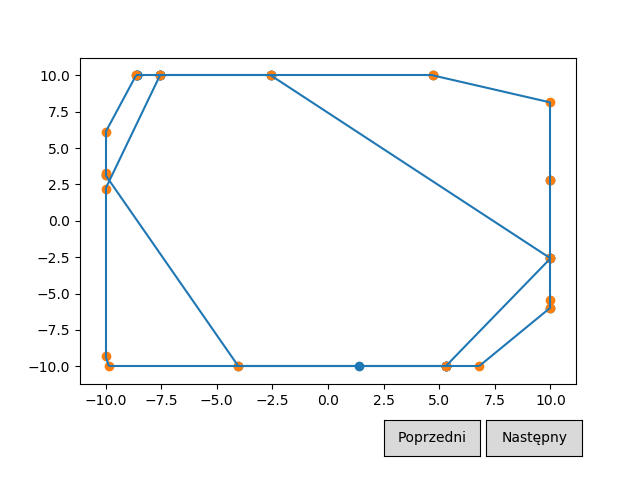

In [442]:
%matplotlib notebook
lines_Jarvis = [[convex_hull_Jarvis[i], convex_hull_Jarvis[(i+1)%len(convex_hull_Jarvis)]] for i in range(len(convex_hull_Jarvis))]
scenes=[Scene([PointsCollection(test_set), PointsCollection(convex_hull_Jarvis)], [LinesCollection(lines_Jarvis)])]
plot = Plot(scenes)
plot.draw()
